# Civil Engineering Machine Learning Project


***
## 1. Data Extraction

In [170]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [171]:

import os
import scipy.io
import numpy as np
import pandas as pd
from math import log10, floor
from datetime import datetime

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

In [172]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Import and select relevant data 

In [173]:
temp1 = pd.read_excel("Type 1.xlsx", sheetname="B1")
temp2 = pd.read_excel("Type 1.xlsx", sheetname="B2")
temp3 = pd.read_excel("Type 1.xlsx", sheetname="B3")

In [174]:
temp1.shape, temp2.shape, temp3.shape

((258735, 37), (138661, 42), (162644, 20))

In [175]:
temp1

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,173,0,00:01:13.212000,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,173,0,00:01:13.505000,NaN,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ID,DDD,HH:MM:SS.mmmuuun,PARA1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,0,00:01:14,0.0143,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
train = temp1.iloc[:,0:20]
test = temp2.iloc[:,0:21]

In [177]:
train = train[train.ID!='ID']
train.dropna(inplace=True)
test = test[test.ID!='ID']
test.dropna(inplace=True)

In [178]:
train.columns

Index(['ID', 'DDD', 'HH:MM:SS.mmmuuun', 'PARA1', 'CH', 'RISE', 'COUN', 'ENER',
       'DURATION', 'AMP', 'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ',
       'I-FRQ', 'SIG-STRNGTH', 'ABS-ENERGY', 'DAMAGE'],
      dtype='object')

In [179]:
test.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG,STRNGTH,ABS-ENERGY,DAMAGE
9,1,0,00:00:57.727000,0.0122,3,1,5,2,142,50,...,0.0002,13,1,45,28,1000,15,113,230.56,1.0
18,1,0,00:01:00.885000,0.0122,3,14,17,20,471,67,...,0.0002,13,2,45,32,142,129,393,7176,1.0
36,1,0,00:01:12.285000,0.0119,3,50,35,41,1400,64,...,0.0002,13,3,45,23,60,262,227,11707,1.0
38,1,0,00:01:12.285000,0.0073,2,1,18,18,666,89,...,0.0002,13,1,45,25,1000,118,334,4150,1.0
40,1,0,00:01:12.285000,0.0122,4,2,1,0,4,46,...,0.0002,12,1,45,0,500,771,0.65,16.68,1.0


In [180]:
test.dtypes

ID                   object
DDD                  object
HH:MM:SS.mmmuuun     object
PARA1                object
CH                   object
RISE                 object
COUN                 object
ENER                 object
DURATION             object
AMP                  object
A-FRQ                object
RMS                  object
ASL                  object
PCNTS                object
THR                  object
R-FRQ                object
I-FRQ                object
SIG                  object
STRNGTH              object
ABS-ENERGY           object
DAMAGE              float64
dtype: object

In [181]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

### Check data frame structure 

In [182]:
train.shape, test.shape

((127718, 20), (68534, 21))

In [183]:
train.dtypes, test.dtypes

(ID                   object
 DDD                  object
 HH:MM:SS.mmmuuun     object
 PARA1                object
 CH                   object
 RISE                 object
 COUN                 object
 ENER                 object
 DURATION             object
 AMP                  object
 A-FRQ                object
 RMS                  object
 ASL                  object
 PCNTS                object
 THR                  object
 R-FRQ                object
 I-FRQ                object
 SIG-STRNGTH          object
 ABS-ENERGY           object
 DAMAGE              float64
 dtype: object, ID                   object
 DDD                  object
 HH:MM:SS.mmmuuun     object
 PARA1                object
 CH                   object
 RISE                 object
 COUN                 object
 ENER                 object
 DURATION             object
 AMP                  object
 A-FRQ                object
 RMS                  object
 ASL                  object
 PCNTS                object

In [184]:
train.head(), test.head()

(  ID DDD HH:MM:SS.mmmuuun   PARA1 CH RISE COUN ENER DURATION AMP A-FRQ  \
 0  1   0  00:01:13.212000  0.0143  2   21    4    2      134  51    30   
 1  1   0  00:01:13.505000  0.0131  4    9    5    2      114  52    44   
 2  1   0  00:01:14.793000  0.0131  2    1    1    0        2  47   500   
 3  1   0  00:01:14.918000  0.0119  2    1    2    0       55  45    36   
 4  1   0  00:01:15.187000  0.0092  2   27   12    8      442  57    27   
 
       RMS ASL PCNTS THR R-FRQ I-FRQ SIG-STRNGTH ABS-ENERGY  DAMAGE  
 0  0.0002  13     2  45    17    95       13088    202.701     1.0  
 1  0.0002  13     1  45    38   111       14372    260.846     1.0  
 2  0.0002  14     1  45     0  1000      283.65      6.438     1.0  
 3  0.0002  14     1  45    18  1000        4188     52.109     1.0  
 4  0.0004  16     2  45    24    74       51280       1296     1.0  ,
   ID DDD HH:MM:SS.mmmuuun   PARA1 CH RISE COUN ENER DURATION AMP  ...    \
 0  1   0  00:00:57.727000  0.0122  3    1    5    

***
## 2. Data Cleaning
### Check and fill missing values 

In [185]:
#train.count(), test.count()

No missing data. Incomplete entries have already been removed.

### Convert to numeric columns 

In [186]:
train['ID'] = train['ID'].astype(int)
train['DDD'] = train['DDD'].astype(int)
train['PARA1'] = train['PARA1'].astype(float)
train['CH'] = train['CH'].astype(int)
train['RISE'] = train['RISE'].astype(int)
train['COUN'] = train['COUN'].astype(int)
train['ENER'] = train['ENER'].astype(int)
train['DURATION'] = train['DURATION'].astype(int)
train['AMP'] = train['AMP'].astype(int)
train['A-FRQ'] = train['A-FRQ'].astype(int)
train['RMS'] = train['RMS'].astype(float)
train['ASL'] = train['ASL'].astype(int)
train['PCNTS'] = train['PCNTS'].astype(int)
train['THR'] = train['THR'].astype(int)
train['R-FRQ'] = train['R-FRQ'].astype(int)
train['I-FRQ'] = train['I-FRQ'].astype(int)
train['SIG-STRNGTH'] = train['SIG-STRNGTH'].astype(float)
train['ABS-ENERGY'] = train['ABS-ENERGY'].astype(float)
train['DAMAGE'] = train['DAMAGE'].astype(int)

train.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
SIG-STRNGTH         float64
ABS-ENERGY          float64
DAMAGE                int32
dtype: object

In [187]:
test['ID'] = test['ID'].astype(int)
test['DDD'] = test['DDD'].astype(int)
test['PARA1'] = test['PARA1'].astype(float)
test['CH'] = test['CH'].astype(int)
test['RISE'] = test['RISE'].astype(int)
test['COUN'] = test['COUN'].astype(int)
test['ENER'] = test['ENER'].astype(int)
test['DURATION'] = test['DURATION'].astype(int)
test['AMP'] = test['AMP'].astype(int)
test['A-FRQ'] = test['A-FRQ'].astype(int)
test['RMS'] = test['RMS'].astype(float)
test['ASL'] = test['ASL'].astype(int)
test['PCNTS'] = test['PCNTS'].astype(int)
test['THR'] = test['THR'].astype(int)
test['R-FRQ'] = test['R-FRQ'].astype(int)
test['I-FRQ'] = test['I-FRQ'].astype(int)
test['ABS-ENERGY'] = test['ABS-ENERGY'].astype(float)
test['DAMAGE'] = test['DAMAGE'].astype(int)

In [188]:
test.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG,STRNGTH,ABS-ENERGY,DAMAGE
0,1,0,00:00:57.727000,0.0122,3,1,5,2,142,50,...,0.0002,13,1,45,28,1000,15,113,230.56,1
1,1,0,00:01:00.885000,0.0122,3,14,17,20,471,67,...,0.0002,13,2,45,32,142,129,393,7176.00,1
2,1,0,00:01:12.285000,0.0119,3,50,35,41,1400,64,...,0.0002,13,3,45,23,60,262,227,11707.00,1
3,1,0,00:01:12.285000,0.0073,2,1,18,18,666,89,...,0.0002,13,1,45,25,1000,118,334,4150.00,1
4,1,0,00:01:12.285000,0.0122,4,2,1,0,4,46,...,0.0002,12,1,45,0,500,771,0.65,16.68,1


In [189]:
test['SIG-STRNGTH'] = (test["SIG"].astype(str).map(str) + test["STRNGTH"].astype(str)).astype(float)
test.drop('SIG',axis=1,inplace=True)
test.drop('STRNGTH',axis=1,inplace=True)
test.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
ABS-ENERGY          float64
DAMAGE                int32
SIG-STRNGTH         float64
dtype: object

In [190]:
test['SIG-STRNGTH'] 

0         15113.00
1        129393.00
2        262227.00
3        118334.00
4          7710.65
5         14216.00
6         12612.00
7          5910.70
8           570.95
9        161931.00
10        90838.00
11        26620.00
12         3184.00
13       359476.00
14       173780.00
15         5850.60
16        17611.00
17         4230.95
18         3620.95
19         4050.65
20         8384.00
21        20679.00
22         4371.00
23         4761.00
24        13319.00
25         3340.00
26         3986.00
27       126810.00
28       348771.00
29        21801.00
           ...    
68504     55412.00
68505     14927.00
68506     68951.00
68507    376172.00
68508      8388.00
68509    259515.00
68510     65731.00
68511      9489.00
68512     62333.00
68513     50288.00
68514      3138.00
68515    407669.00
68516    186578.00
68517     46641.00
68518    148135.00
68519      9781.00
68520    484913.00
68521     16639.00
68522      3352.00
68523      4743.00
68524    656940.00
68525    341

In [191]:
train.to_excel("trainData.xlsx")
test.to_excel("testData.xlsx")

### Normalize Data

In [192]:
# mn = pd.DataFrame.mean(data)
# vr = pd.DataFrame.var(data)

# data.RISE = (data.RISE - mn.RISE) / vr.RISE
# data.COUN = (data.COUN - mn.COUN) / vr.COUN
# data.ENER = (data.ENER - mn.ENER) / vr.ENER
# data.DURATION = (data.DURATION - mn.DURATION) / vr.DURATION
# data.AMP = (data.AMP - mn.AMP) / vr.AMP
# data.A_FRQ = (data.A_FRQ - mn.A_FRQ) / vr.A_FRQ
# data.SIG_STRNGTH = (data.SIG_STRNGTH - mn.SIG_STRNGTH) / vr.SIG_STRNGTH
# data.ABS_ENERGY = (data.ABS_ENERGY - mn.ABS_ENERGY) / vr.ABS_ENERGY

In [193]:
train['HR'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
train['MIN'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
train['SEC'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
train['USEC'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [194]:
test['HR'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
test['MIN'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
test['SEC'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
test['USEC'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [195]:
train.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,...,45,17,95,13088.00,202.701,1,0,1,13,212000
1,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,...,45,38,111,14372.00,260.846,1,0,1,13,505000
2,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,...,45,0,1000,283.65,6.438,1,0,1,14,793000
3,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,...,45,18,1000,4188.00,52.109,1,0,1,14,918000
4,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,...,45,24,74,51280.00,1296.000,1,0,1,15,187000


In [196]:
test.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,THR,R-FRQ,I-FRQ,ABS-ENERGY,DAMAGE,SIG-STRNGTH,HR,MIN,SEC,USEC
0,1,0,00:00:57.727000,0.0122,3,1,5,2,142,50,...,45,28,1000,230.56,1,15113.00,0,0,57,727000
1,1,0,00:01:00.885000,0.0122,3,14,17,20,471,67,...,45,32,142,7176.00,1,129393.00,0,1,0,885000
2,1,0,00:01:12.285000,0.0119,3,50,35,41,1400,64,...,45,23,60,11707.00,1,262227.00,0,1,12,285000
3,1,0,00:01:12.285000,0.0073,2,1,18,18,666,89,...,45,25,1000,4150.00,1,118334.00,0,1,12,285000
4,1,0,00:01:12.285000,0.0122,4,2,1,0,4,46,...,45,0,500,16.68,1,7710.65,0,1,12,285000


In [168]:
X = train.copy()
y = X.pop('DAMAGE')
Z_X = test.copy()
Z_y = Z_X.pop('DAMAGE')

In [169]:
X

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,...,45,17,95,13088.00,202.701,1,0,1,13,212000
1,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,...,45,38,111,14372.00,260.846,1,0,1,13,505000
2,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,...,45,0,1000,283.65,6.438,1,0,1,14,793000
3,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,...,45,18,1000,4188.00,52.109,1,0,1,14,918000
4,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,...,45,24,74,51280.00,1296.000,1,0,1,15,187000
5,1,0,00:01:15.596000,0.0113,2,10,1,0,12,49,...,45,0,100,2147.00,49.321,1,0,1,15,596000
6,1,0,00:01:15.859000,0.0119,2,1,1,0,2,47,...,45,0,1000,369.05,8.888,1,0,1,15,859000
7,1,0,00:01:16.265000,0.0162,2,960,5,7,1353,50,...,45,7,2,48596.00,486.100,1,0,1,16,265000
8,1,0,00:01:16.266000,0.0107,3,1,1,0,1,45,...,45,0,1000,115.90,2.124,1,0,1,16,266000
9,1,0,00:01:16.334000,0.0110,3,23,3,1,69,48,...,45,21,86,7241.00,107.876,1,0,1,16,334000


In [140]:
X.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
X.drop('DAMAGE',axis=1,inplace=True)
X.drop('SIG-STRNGTH',axis=1,inplace=True)

In [141]:
Z_X.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
Z_X.drop('DAMAGE',axis=1,inplace=True)
Z_X.drop('SIG-STRNGTH',axis=1,inplace=True)

In [142]:
X.columns

Index(['ID', 'DDD', 'PARA1', 'CH', 'RISE', 'COUN', 'ENER', 'DURATION', 'AMP',
       'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 'I-FRQ', 'ABS-ENERGY',
       'HR', 'MIN', 'SEC', 'USEC'],
      dtype='object')

In [143]:
Z_X = Z_X[X.columns]

In [144]:
Z_X.columns

Index(['ID', 'DDD', 'PARA1', 'CH', 'RISE', 'COUN', 'ENER', 'DURATION', 'AMP',
       'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 'I-FRQ', 'ABS-ENERGY',
       'HR', 'MIN', 'SEC', 'USEC'],
      dtype='object')

Split Train/Test Sets

In [145]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [146]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((102174, 21), (25544, 21), (102174,), (25544,))

***
## 3. Train and Evaluate the Model

### XGBoost MODEL

### XGBoost Setup

In [147]:
# Specify the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(Z_X)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [148]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model1 = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model1.best_score)

[0]	train-rmse:2.63855	valid-rmse:2.63647
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.37473	valid-rmse:2.37287
[2]	train-rmse:2.14787	valid-rmse:2.14616
[3]	train-rmse:1.93315	valid-rmse:1.93163
[4]	train-rmse:1.7399	valid-rmse:1.73856
[5]	train-rmse:1.56599	valid-rmse:1.56481
[6]	train-rmse:1.40947	valid-rmse:1.40843
[7]	train-rmse:1.26861	valid-rmse:1.2677
[8]	train-rmse:1.14184	valid-rmse:1.14103
[9]	train-rmse:1.02774	valid-rmse:1.02704
[10]	train-rmse:0.925068	valid-rmse:0.924449
[11]	train-rmse:0.832667	valid-rmse:0.832124
[12]	train-rmse:0.74952	valid-rmse:0.749054
[13]	train-rmse:0.674683	valid-rmse:0.674287
[14]	train-rmse:0.607337	valid-rmse:0.607001
[15]	train-rmse:0.546726	valid-rmse:0.546415
[16]	train-rmse:0.492196	valid-rmse:0.491933
[17]	train-rmse:0.445832	valid-rmse:0.445595
[18]	train-rmse:0.401397	valid-rmse:0.401199
[19]	train-rmse:0.36141	valid-rms

[179]	train-rmse:0.009064	valid-rmse:0.011141
[180]	train-rmse:0.009047	valid-rmse:0.011129
[181]	train-rmse:0.009034	valid-rmse:0.011135
[182]	train-rmse:0.009027	valid-rmse:0.011127
[183]	train-rmse:0.009012	valid-rmse:0.011127
[184]	train-rmse:0.008971	valid-rmse:0.011063
[185]	train-rmse:0.008955	valid-rmse:0.011052
[186]	train-rmse:0.008942	valid-rmse:0.011037
[187]	train-rmse:0.00893	valid-rmse:0.011029
[188]	train-rmse:0.008911	valid-rmse:0.011013
[189]	train-rmse:0.008902	valid-rmse:0.011014
[190]	train-rmse:0.008887	valid-rmse:0.011005
[191]	train-rmse:0.008883	valid-rmse:0.011006
[192]	train-rmse:0.008868	valid-rmse:0.010994
[193]	train-rmse:0.008794	valid-rmse:0.010934
[194]	train-rmse:0.008778	valid-rmse:0.010923
[195]	train-rmse:0.008729	valid-rmse:0.010882
[196]	train-rmse:0.008715	valid-rmse:0.01088
[197]	train-rmse:0.008699	valid-rmse:0.01086
[198]	train-rmse:0.008679	valid-rmse:0.010865
[199]	train-rmse:0.008657	valid-rmse:0.010845
[200]	train-rmse:0.008647	valid-rmse:

[358]	train-rmse:0.006777	valid-rmse:0.009427
[359]	train-rmse:0.006774	valid-rmse:0.009427
[360]	train-rmse:0.006767	valid-rmse:0.009425
[361]	train-rmse:0.006763	valid-rmse:0.009432
[362]	train-rmse:0.00674	valid-rmse:0.009416
[363]	train-rmse:0.006731	valid-rmse:0.009403
[364]	train-rmse:0.006697	valid-rmse:0.009366
[365]	train-rmse:0.006684	valid-rmse:0.009354
[366]	train-rmse:0.00668	valid-rmse:0.009348
[367]	train-rmse:0.006678	valid-rmse:0.009345
[368]	train-rmse:0.006674	valid-rmse:0.009354
[369]	train-rmse:0.006668	valid-rmse:0.009352
[370]	train-rmse:0.006661	valid-rmse:0.009352
[371]	train-rmse:0.006653	valid-rmse:0.009351
[372]	train-rmse:0.006645	valid-rmse:0.00935
[373]	train-rmse:0.006625	valid-rmse:0.00933
[374]	train-rmse:0.006607	valid-rmse:0.009312
[375]	train-rmse:0.006594	valid-rmse:0.009291
[376]	train-rmse:0.006591	valid-rmse:0.00929
[377]	train-rmse:0.006583	valid-rmse:0.009292
[378]	train-rmse:0.006577	valid-rmse:0.009291
[379]	train-rmse:0.006576	valid-rmse:0.

[537]	train-rmse:0.005678	valid-rmse:0.008805
[538]	train-rmse:0.005668	valid-rmse:0.008786
[539]	train-rmse:0.005664	valid-rmse:0.008786
[540]	train-rmse:0.005661	valid-rmse:0.008786
[541]	train-rmse:0.005657	valid-rmse:0.008795
[542]	train-rmse:0.005654	valid-rmse:0.008791
[543]	train-rmse:0.005653	valid-rmse:0.008793
[544]	train-rmse:0.005651	valid-rmse:0.008795
[545]	train-rmse:0.005644	valid-rmse:0.008787
[546]	train-rmse:0.005641	valid-rmse:0.008784
[547]	train-rmse:0.005636	valid-rmse:0.008774
[548]	train-rmse:0.00563	valid-rmse:0.008769
[549]	train-rmse:0.005626	valid-rmse:0.00877
[550]	train-rmse:0.005625	valid-rmse:0.008771
[551]	train-rmse:0.005621	valid-rmse:0.008766
[552]	train-rmse:0.005621	valid-rmse:0.008765
[553]	train-rmse:0.005619	valid-rmse:0.008764
[554]	train-rmse:0.005615	valid-rmse:0.008763
[555]	train-rmse:0.005611	valid-rmse:0.008756
[556]	train-rmse:0.005607	valid-rmse:0.008752
[557]	train-rmse:0.005594	valid-rmse:0.008745
[558]	train-rmse:0.005593	valid-rmse

### Train/Validation Set Evaluation 

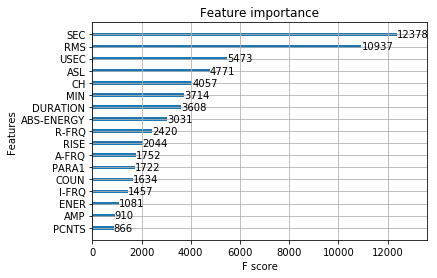

In [149]:
xgb.plot_importance(model1, height=0.3)

### Prediction

In [150]:
# evaluate the model
pred = model1.predict(dtest)

In [151]:
pred = np.exp(pred) - 1

In [152]:
len(pred), len(Z_y)

(68534, 68534)

In [153]:
np.mean(pred-Z_y)

23.615905732677422

In [154]:
# fit model no training data
model2 = xgb.XGBClassifier()
model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [155]:
# make predictions for test data
Z_h = model2.predict(Z_X)
Z_h

array([1, 1, 1, ..., 4, 4, 4])

In [156]:
predictions = [round(value) for value in Z_h]

In [157]:
np.mean(Z_h == Z_y)

0.59494557445939245

In [158]:
result["DAMAGE"] = predictions

NameError: name 'result' is not defined

In [474]:
result.to_excel("resultTest.xlsx")

In [159]:
# evaluate predictions
accuracy = accuracy_score(Z_y, Z_h)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.49%


### RandomTreeClassifier MODEL

### Check feature importance

In [160]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X,y)

In [161]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

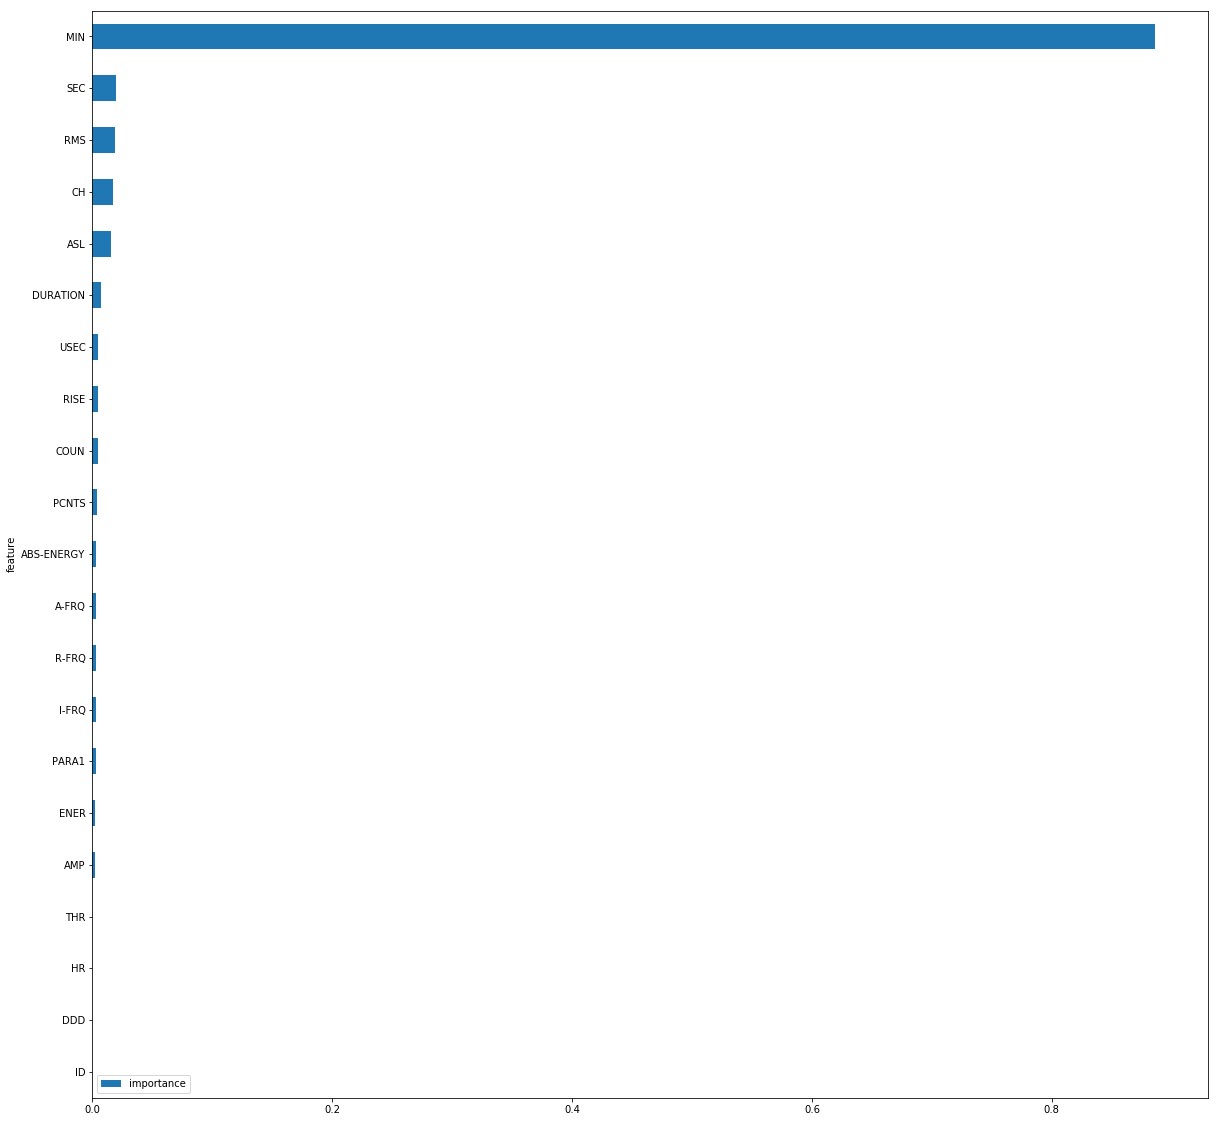

In [162]:
features.plot(kind='barh', figsize=(20, 20))

### Hyperparameter tuning

In [163]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
                'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model3 = RandomForestClassifier(**parameters)
model3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
xval = cross_val_score(model3, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.97310344574437391

In [165]:
Z_h = model3.predict(Z_X)

In [166]:
np.mean(Z_h == Z_y)

0.57466367058686196

In [167]:
pd.DataFrame(Z_h, Z_y)

,0
DAMAGE,
1,3
1,3
1,3
1,3
1,3
1,3
1,3
1,3
1,3


***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline